In [36]:
import os
import pandas as pd
import numpy as np
import numpy.typing as npt
import sys
import math
import sunpy.visualization.colormaps.cm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
np.set_printoptions(threshold=sys.maxsize)

sdo_resolution = 440
length_colonal_loop_in_px = 317.418
width_coronal_loop_in_px = 29

In [37]:
def get_cmap_by_channel(channel: int):
    if channel not in [94, 131, 171, 193, 211, 304, 335]:
        raise Exception(
            f"TimeDistancePlot::get_time_distance_plot_as_qpixmap_using_cmap_of_channel({channel}). Not correct channel")

    cm = {94: sunpy.visualization.colormaps.cm.sdoaia94,
          131: sunpy.visualization.colormaps.cm.sdoaia131,
          171: sunpy.visualization.colormaps.cm.sdoaia171,
          193: sunpy.visualization.colormaps.cm.sdoaia193,
          211: sunpy.visualization.colormaps.cm.sdoaia211,
          304: sunpy.visualization.colormaps.cm.sdoaia304,
          335: sunpy.visualization.colormaps.cm.sdoaia335
          }[channel]
    return cm

In [38]:
def get_time_distance_plot_as_numpy_array(channel: int) -> npt.NDArray:
    return np.load(f"tdp_A{channel}.npy")

In [39]:
def get_head_value_of_metafile(metafile:str, head: str) -> int:
        with open(metafile) as f:
            content_of_metafile = f.readlines()
            for line in content_of_metafile:
                line = line.replace(' ', '')
                line = line.replace('\n', '')
                if line.split('=')[0] == head:
                    return int(line.split('=')[1])
        raise Exception(f"Not found head = {head}")

In [40]:
def get_number_of_slice_along_loop(channel: int):
    return get_head_value_of_metafile(f"tdp_A{channel}_metadata.txt", "NUMBER_OF_SLICE_ALONG_LOOP")

def get_number_segments_of_bezier_curve():
    return 25

def get_number_of_pixels_per_time_step(channel: int):
    return get_head_value_of_metafile(f"tdp_A{channel}_metadata.txt", "NUMBER_OF_PIXELS_PER_TIME_STEP")


In [41]:
def get_segment_of_time_distance_plot_corresponding_bezier_segment(time_distance_plot: npt.NDArray, index_of_bezier_segment: int) -> npt.NDArray:
    height_of_time_distance_plot = time_distance_plot.shape[0]
    number_segments_of_bezier_curve = get_number_segments_of_bezier_curve()
    
    if index_of_bezier_segment >= number_segments_of_bezier_curve:
        raise Exception(f"Segment with index = {index_of_bezier_segment} not found")

    number_of_slice_in_bezier_segment =  height_of_time_distance_plot / number_segments_of_bezier_curve

    start_border_of_segment_in_time_distance_plot = int(number_of_slice_in_bezier_segment * index_of_bezier_segment)
    end_border_of_segment_in_time_distance_plot = int(number_of_slice_in_bezier_segment * (index_of_bezier_segment + 1))
    return time_distance_plot[start_border_of_segment_in_time_distance_plot: end_border_of_segment_in_time_distance_plot]

In [42]:
def get_total_intensivity_of_bezier_segment(time_distance_plot: npt.NDArray, index_of_bezier_segment: int) -> float:
    segment_of_time_distance_plot = get_segment_of_time_distance_plot_corresponding_bezier_segment(time_distance_plot, index_of_bezier_segment)
    return segment_of_time_distance_plot.mean()

In [43]:
def get_intensivity_of_bezier_segment_by_t(time_distance_plot, index_of_bezier_segment, t: int) -> float: # where t is number [0, length_of_time_distance_plot]
    segment_of_time_distance_plot = get_segment_of_time_distance_plot_corresponding_bezier_segment(time_distance_plot, index_of_bezier_segment)
    return segment_of_time_distance_plot.T[t].mean()

In [44]:
def get_index_of_most_intense_bezier_segment(time_distance_plot: npt.NDArray) -> int:
    index_of_most_intense_bezier_segment = 0
    intensivity_of_most_intense_bezier_segment = 0
    for index_of_bezier_segment in range(get_number_segments_of_bezier_curve()):
        intensivity_of_bezier_segment = get_total_intensivity_of_bezier_segment(time_distance_plot, index_of_bezier_segment)
        if intensivity_of_bezier_segment > intensivity_of_most_intense_bezier_segment:
            intensivity_of_most_intense_bezier_segment = intensivity_of_bezier_segment
            index_of_most_intense_bezier_segment = index_of_bezier_segment
    return index_of_most_intense_bezier_segment
    

In [45]:
time_distance_plot_A94 = get_time_distance_plot_as_numpy_array(channel = 94)
time_distance_plot_A131 = get_time_distance_plot_as_numpy_array(channel = 131)
time_distance_plot_A171 = get_time_distance_plot_as_numpy_array(channel = 171)
time_distance_plot_A193 = get_time_distance_plot_as_numpy_array(channel = 193)
time_distance_plot_A211 = get_time_distance_plot_as_numpy_array(channel = 211)
time_distance_plot_A304 = get_time_distance_plot_as_numpy_array(channel = 304)
time_distance_plot_A335 = get_time_distance_plot_as_numpy_array(channel = 335)

In [46]:
index_of_most_intense_segment = get_index_of_most_intense_bezier_segment(time_distance_plot_A131)
print(f"most intense segment = {index_of_most_intense_segment}")

most intense segment = 11


In [47]:
def show_time_distance_plot(time_distance_plot: npt.NDArray, channel: int) -> None:
    length_of_time_distance_plot = time_distance_plot.shape[1]
    height_of_time_distance_plot = time_distance_plot.shape[0]
    number_of_bezier_segments = get_number_segments_of_bezier_curve()
    number_of_slice_per_bezier_segment = int(height_of_time_distance_plot / number_of_bezier_segments)
    borders = [number_of_slice_per_bezier_segment * i for i in range(number_of_bezier_segments)]

    #for border in borders:
    #    plt.axhline(y = border, color = 'r', linestyle = '-')

    plt.axhline(y = borders[10], color = 'r', linestyle = '-')
    plt.axhline(y = borders[11], color = 'r', linestyle = '-')

    plt.ylabel("Дистанция вдоль петли, Mm")
    plt.xlabel("Время, С")
    plt.title(f"Канал {channel} A")
    yticks = [i * sdo_resolution / 1000 for i in range(320,0, -32)]
    plt.xticks(range(0, 250, 50), [8 * i for i in range(0, 250, 50)])
    plt.yticks(range(0, 400, 40), yticks)
    
    cm = get_cmap_by_channel(channel)
    plt.imshow(time_distance_plot, cmap=cm)
    plt.savefig(f"TimeDistancePlotSelectedSegment_A{channel}.png")

''

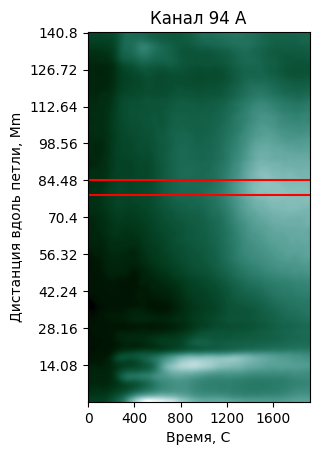

In [48]:
show_time_distance_plot(time_distance_plot_A94, channel = 94)
;

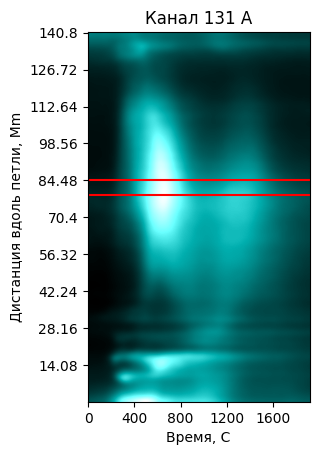

In [49]:
show_time_distance_plot(time_distance_plot_A131, channel = 131)

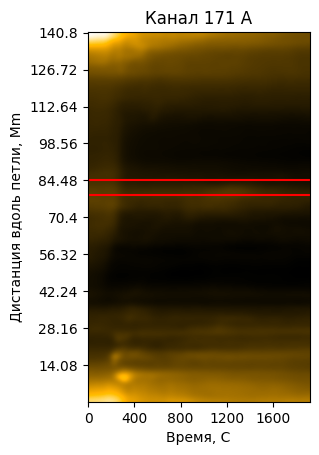

In [50]:
show_time_distance_plot(time_distance_plot_A171, channel = 171)

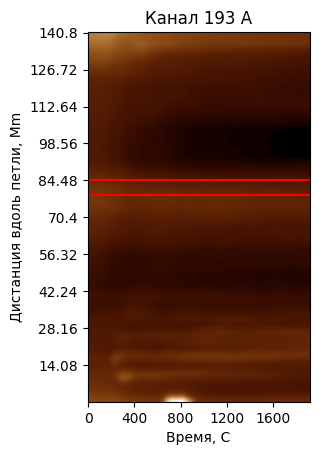

In [51]:
show_time_distance_plot(time_distance_plot_A193, channel = 193)

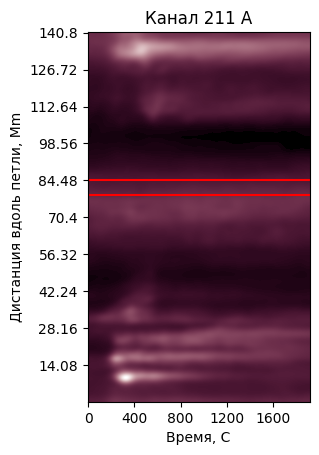

In [52]:
show_time_distance_plot(time_distance_plot_A304, channel = 211)

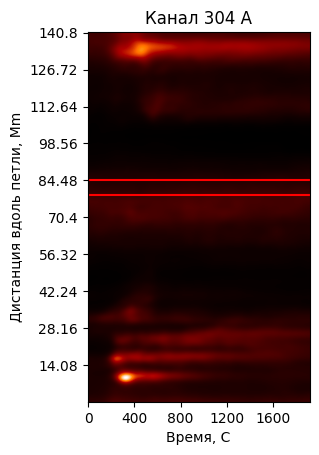

In [53]:
show_time_distance_plot(time_distance_plot_A304, channel = 304)

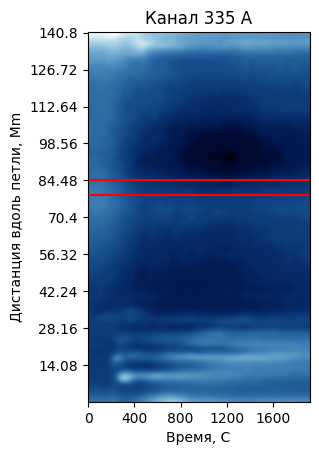

In [54]:
show_time_distance_plot(time_distance_plot_A335, channel = 335)

In [55]:
index_of_most_intense_bezier_segment = get_index_of_most_intense_bezier_segment(time_distance_plot_A131)
print(f"most instence segment = {index_of_most_intense_bezier_segment}")

most instence segment = 11


In [56]:
def get_tresp_interpolated(channel_names):
    data = get_tresp_function(channel_names)
    result = {}
    for channel in channel_names:
        result[channel] = interp1d(x=data['T,K'], y=data[channel],
                                   kind='quadratic')
    return result

In [57]:
def get_tresp_function(channel_names):
    path = os.path.abspath('tresp_2019.txt')
    data = pd.read_csv(path, delimiter='\s+', index_col=False)
    data['T,K'] = np.power(10, data.TMP)
    return data[['T,K'] + channel_names]

In [58]:
class SITES():
    def __init__(self, t_min, t_max, n_bins, channels):
        self.__t_min = t_min
        self.__t_max = t_max
        self.__n_bins = n_bins
        self.__channels = channels
        self.__t_bins, self.__dt = self.__create_log_bins()
        self.__resp = self.__get_resp_matrix()
        self.__chan_uncer = self.__calc_chan_uncer()

    def __create_log_bins(self):
        t_bins = np.linspace(np.log10(self.__t_min), np.log10(
            self.__t_max), self.__n_bins + 1)
        t_bins = np.power(10, t_bins)
        dt = [t2 - t1 for t2, t1 in zip(t_bins[1:], t_bins[:-1])]

        return t_bins, np.array(dt)

    def __get_resp_matrix(self):
        resp = get_tresp_interpolated(self.__channels)
        resp_matrix = []

        for channel in self.__channels:
            row = []
            for t_mid in [t + 0.5 * dt for t, dt in zip(self.__t_bins[:-1], self.__dt)]:
                row.append(resp[channel](t_mid))

            resp_matrix.append(row)

        return np.array(resp_matrix)

    def __calc_chan_uncer(self):
        e = {'304': 0.5, '131': 0.5, '94': 0.5, '171': 0.25,
             '193': 0.25, '211': 0.25, '335': 0.25}
        uncert = []
        for channel in self.__channels:
            df = get_tresp_function([channel])
            df[channel + 'sh'] = df[channel].shift(-1)
            df['dt'] = -df['T,K'].diff(-1)
            df['int'] = 0.5 * (df[channel + 'sh'] + df[channel]) * df['dt']
            num = df.loc[(df['T,K'] < self.__t_min) | (
                (df['T,K'] > self.__t_max)), 'int'].sum()
            den = df.loc[(df['T,K'] >= self.__t_min) & (
                (df['T,K'] <= self.__t_max)), 'int'].sum()
            er = num / den

            uncert.append(np.sqrt(e[channel]**2 + er**2))

        return np.array(uncert)

    def __get_channel_weights(self, i):
        er = self.__chan_uncer
        er_i = np.divide(1, i)
        w = np.divide(1, np.sqrt(er_i + er * er))
        return w

    def calc_dem_iter(self, i, kernel_width=3.2):
        a = self.__rel_resp * (self.__resp * self.__dt)
        b = ((self.__resp*self.__resp) @ (self.__dt*self.__dt))
        dem = a * (i / b)[:, None]
        dem = dem.sum(axis=0)
        dem = gaussian_filter1d(dem, kernel_width)
        return dem

    def calc_intens(self, dem):
        return self.__resp @ (dem*self.__dt)

    def calc_intens_without_edge(self, dem):
        return self.__resp[:, 1:-1] @ (dem*self.__dt)[1:-1]

    def calc_dem(self, i, tol=0.1, max_iter=300, kernel_width=3.2):
        w = self.__get_channel_weights(i)
        w_sum = w.sum()
        # Calculate relative response matrix
        self.__rel_resp = (w[:, None] * self.__resp) / (w @ self.__resp)
        # Calculate matrices for calculation
        a = self.__rel_resp * (self.__resp * self.__dt)
        b = ((self.__resp*self.__resp) @ (self.__dt*self.__dt))
        ker = self.g_kernel(kernel_width)
        dem = np.zeros(self.__n_bins)
        res = i.copy()
        er = 1
        n_iter = 0
        while er > tol and n_iter < max_iter:
            delta = a * (res / b)[:, None]
            delta = delta.sum(axis=0)
            # dem += gaussian_filter1d(delta, kernel_width)
            dem += self.g_filter(delta, ker)
            dem[dem <= 0] = 0
            res = i - self.calc_intens(dem)
            er = np.dot(w, np.abs(res / i)) / w_sum
            n_iter += 1
        return dem, er

    def g_kernel(self, sigma):
        radius = int(4 * float(sigma) + 0.5)
        exponent_range = np.arange(1)
        sigma2 = sigma * sigma
        x = np.arange(-radius, radius+1)
        phi_x = np.exp(-0.5 / sigma2 * x ** 2)
        phi_x = phi_x / phi_x.sum()
        return phi_x[::-1]

    def g_filter(self, x, ker):
        return np.convolve(x, ker, mode='same')

    def calc_em(self, dem):
        return np.sum(dem * self.__dt)

    def calc_temp(self, dem):
        t_mid = np.array(
            [t + 0.5 * dt for t, dt in zip(self.__t_bins[:-1], self.__dt)])
        return np.sum((dem * self.__dt) * t_mid) / np.sum(dem * self.__dt)

    def calc_energy_isobaric(self, dem):
        t_mid = np.array(
            [t + 0.5 * dt for t, dt in zip(self.__t_bins[:-1], self.__dt)])
        emissions = dem * self.__dt
        energy = (emissions * (t_mid * t_mid)).sum()
        energy *= 1.5 * (K_B**2) * S0 / P0
        return energy

    def test_int(self):
        A = 1.4e21
        wt = 0.9e6
        tc = 1.4e6
        t = np.array(
            [t + 0.5 * dt for t, dt in zip(self.__t_bins[:-1], self.__dt)])
        dem = A * np.exp(-np.power(np.divide(t - tc, wt), 2))
        return self.calc_intens(dem), dem

    def test_int2(self):
        A = 1.6e21
        wt = 0.35e6
        tc = 0.8e6
        t = np.array(
            [t + 0.5 * dt for t, dt in zip(self.__t_bins[:-1], self.__dt)])
        dem = A * np.exp(-np.power(np.divide(t - tc, wt), 2))

        wt = 3e6
        tc = 4.5e6
        dem += A * np.exp(-np.power(np.divide(t - tc, wt), 2))
        dem += 1e20
        return self.calc_intens(dem), dem

    def get_temps(self):
        return np.array([t + 0.5 * dt for t, dt in zip(self.__t_bins[:-1], self.__dt)])

In [59]:
def get_intensivity_by_t_from_time_distance_plot(time_distance_plot):
    length_of_time_distance_plot = time_distance_plot.shape[1]
    t_values = [t for t in range(length_of_time_distance_plot)]
    return [get_intensivity_of_bezier_segment_by_t(time_distance_plot, index_of_most_intense_bezier_segment, t) for t in t_values]

In [60]:
def calculate_temp_plot():
    t_min = 0.07e6
    t_max = 20e6
    n_bins = 43
    channels = ['94', '131', '171', '193', '211', '304']
    sites = SITES(t_min, t_max, n_bins, channels)

    L = time_distance_plot_A94.shape[1]
    H = time_distance_plot_A94.shape[0]
    
    plot = np.zeros((H,L))
    for x in range(L):
        for y in range(H):
            I_94A = time_distance_plot_A94[y][x]
            I_131A = time_distance_plot_A131[y][x]
            I_171A = time_distance_plot_A171[y][x]
            I_193A = time_distance_plot_A193[y][x]
            I_211A = time_distance_plot_A211[y][x]
            I_304A = time_distance_plot_A304[y][x]
            I_335A = time_distance_plot_A335[y][x]

            dem, error = sites.calc_dem([I_94A, I_131A, I_171A, I_193A, I_211A, I_304A])
            t = sites.calc_temp(dem)
            plot[y][x] = t
    return plot

In [61]:
temp_plot = calculate_temp_plot()

In [62]:
def show_temp_plot(plot):
    im = plt.imshow(plot) 
    yticks = [i * sdo_resolution / 1000 for i in range(320,0, -32)]
    plt.xticks(range(0, 250, 50), [8 * i for i in range(0, 250, 50)])
    plt.yticks(range(0, 400, 40), yticks)
    cb = plt.colorbar(im)
    cb.set_label("Температура, K")
    plt.ylabel("Дистанция вдоль петли, Mm")
    plt.xlabel("Время, С")
    plt.savefig("Temp.png")
    plt.show()

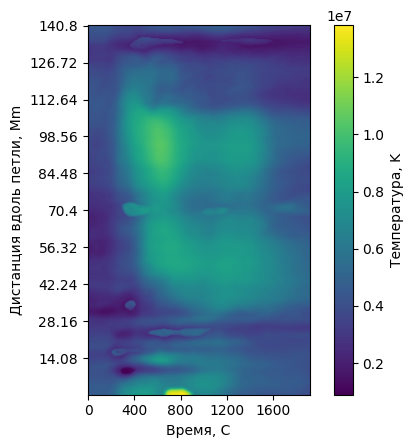

In [63]:
show_temp_plot(temp_plot)

In [64]:
def calculate_em_plot():
    t_min = 0.07e6
    t_max = 20e6
    n_bins = 43
    channels = ['94', '131', '171', '193', '211', '304']
    sites = SITES(t_min, t_max, n_bins, channels)
    
    L = time_distance_plot_A94.shape[1]
    H = time_distance_plot_A94.shape[0]
    plot = np.zeros((H,L))
    for x in range(L):
        for y in range(H):
            I_94A = time_distance_plot_A94[y][x]
            I_131A = time_distance_plot_A131[y][x]
            I_171A = time_distance_plot_A171[y][x]
            I_193A = time_distance_plot_A193[y][x]
            I_211A = time_distance_plot_A211[y][x]
            I_304A = time_distance_plot_A304[y][x]
            I_335A = time_distance_plot_A335[y][x]
            dem, error = sites.calc_dem([I_94A, I_131A, I_171A, I_193A, I_211A, I_304A])
            em = sites.calc_em(dem)
            plot[y][x] = em
    return plot

In [65]:
em_plot = calculate_em_plot()

In [66]:
def show_em_plot(plot):
    im = plt.imshow(plot) 
    yticks = [i * sdo_resolution / 1000 for i in range(320,0, -32)]
    plt.xticks(range(0, 250, 50), [8 * i for i in range(0, 250, 50)])
    plt.yticks(range(0, 400, 40), yticks)
    cb = plt.colorbar(im)
    cb.set_label("Мера эмиссии, $см^-{3}$")
    plt.savefig("EmPlot.png")
    plt.ylabel("Дистанция вдоль петли, Mm")
    plt.xlabel("Время, С")
    plt.savefig("EmPlot.png")
    plt.show()

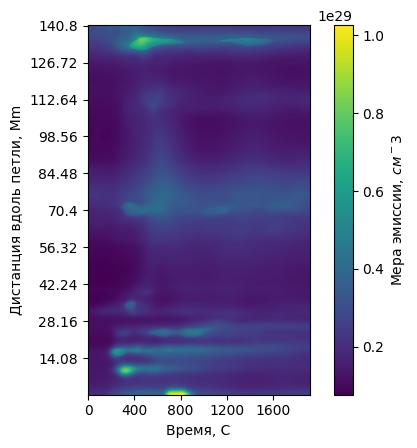

In [67]:
show_em_plot(em_plot)

In [68]:
def caclulate_temp_dependence():
    t_min = 0.07e6
    t_max = 20e6
    n_bins = 43
    channels = ['94', '131', '171', '193', '211', '304', '335']
    sites = SITES(t_min, t_max, n_bins, channels)

    L = time_distance_plot_A94.shape[1]
    H = time_distance_plot_A94.shape[0]
    intensivity_from_A94 = get_intensivity_by_t_from_time_distance_plot(time_distance_plot_A94)
    intensivity_from_A131 = get_intensivity_by_t_from_time_distance_plot(time_distance_plot_A131)
    intensivity_from_A171 = get_intensivity_by_t_from_time_distance_plot(time_distance_plot_A171)
    intensivity_from_A193 = get_intensivity_by_t_from_time_distance_plot(time_distance_plot_A193)
    intensivity_from_A211 = get_intensivity_by_t_from_time_distance_plot(time_distance_plot_A211)
    intensivity_from_A304 = get_intensivity_by_t_from_time_distance_plot(time_distance_plot_A304)
    intensivity_from_A335 = get_intensivity_by_t_from_time_distance_plot(time_distance_plot_A335)

    temperatures = []
    for i in range(40, L):
        I_94A = intensivity_from_A94[i]
        I_131A = intensivity_from_A131[i]
        I_171A = intensivity_from_A171[i]
        I_193A = intensivity_from_A193[i]
        I_211A = intensivity_from_A211[i]
        I_304A = intensivity_from_A304[i]
        I_335A = intensivity_from_A335[i]
    
        dem, error = sites.calc_dem([I_94A, I_131A, I_171A, I_193A, I_211A, I_304A, I_335A])
        t = sites.calc_temp(dem)
        temperatures.append(t)
    return temperatures

In [69]:
temp_dependence = caclulate_temp_dependence()

In [70]:
def show_temp_dependence(temp_dependence):
    L = time_distance_plot_A94.shape[1]
    times = [8 * i for i in range(40, L)]
    plt.figure(figsize=(5, 2.7), layout='constrained')
    plt.plot(times, temp_dependence)
    plt.xlabel('Время , C')
    plt.ylabel('Температура, K')
    plt.savefig("TempDependence.png")
    plt.show()

In [71]:
def calculate_em_dependence():
    t_min = 0.07e6
    t_max = 20e6
    n_bins = 43
    channels = ['94', '131', '171', '193', '211', '304', '335']
    sites = SITES(t_min, t_max, n_bins, channels)

    L = time_distance_plot_A94.shape[1]
    H = time_distance_plot_A94.shape[0]
    intensivity_from_A94 = get_intensivity_by_t_from_time_distance_plot(time_distance_plot_A94)
    intensivity_from_A131 = get_intensivity_by_t_from_time_distance_plot(time_distance_plot_A131)
    intensivity_from_A171 = get_intensivity_by_t_from_time_distance_plot(time_distance_plot_A171)
    intensivity_from_A193 = get_intensivity_by_t_from_time_distance_plot(time_distance_plot_A193)
    intensivity_from_A211 = get_intensivity_by_t_from_time_distance_plot(time_distance_plot_A211)
    intensivity_from_A304 = get_intensivity_by_t_from_time_distance_plot(time_distance_plot_A304)
    intensivity_from_A335 = get_intensivity_by_t_from_time_distance_plot(time_distance_plot_A335)

    em_values = []
    for i in range(40, L):
        I_94A = intensivity_from_A94[i]
        I_131A = intensivity_from_A131[i]
        I_171A = intensivity_from_A171[i]
        I_193A = intensivity_from_A193[i]
        I_211A = intensivity_from_A211[i]
        I_304A = intensivity_from_A304[i]
        I_335A = intensivity_from_A335[i]
    
        dem, error = sites.calc_dem([I_94A, I_131A, I_171A, I_193A, I_211A, I_304A, I_335A])
        em = sites.calc_em(dem)
        em_values.append(em)
    return em_values

In [72]:
def calculate_electron_concentration_dependence(): 
    width_coronal_loop_in_cm = width_coronal_loop_in_px * sdo_resolution * 100000
    em_dependence = calculate_em_dependence()
    density_dependce = [math.sqrt(em/(width_coronal_loop_in_cm)) for em in em_dependence]
    return density_dependce

In [73]:
electron_concentration_dependence = calculate_electron_concentration_dependence()

In [74]:
def show_electron_concentration_dependence(electron_concentration_dependence):
    L = time_distance_plot_A94.shape[1]
    times = [8 * i for i in range(40, L)]
    plt.figure(figsize=(5, 2.7), layout='constrained')
    plt.plot(times, electron_concentration_dependence)
    plt.xlabel('Время , C')
    plt.ylabel('Концентрация электронов, $см^-{3}$')
    plt.savefig("TempDependence.png")
    plt.show()

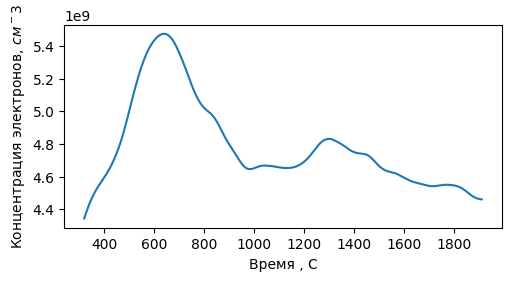

In [75]:
show_electron_concentration_dependence(electron_concentration_dependence)

In [76]:
def trend(t, c0, c1, c2):
    return c2 * t**2 + c1 * t + c0

def wave(t, a, p, phi, dec):
    return a * np.exp(-t * dec) * np.sin(2 * np.pi / p *t + phi)

def fit_func(t, a, p, phi, dec, c0, c1, c2):
    return wave(t, a, p, phi, dec) + trend(t, c0, c1, c2)

In [77]:
def calculate_fited_electron_concentration_dependence(electron_concentration_dependence):
    L = time_distance_plot_A94.shape[1]
    times = [8 * i for i in range(40, L)]
    x_values = times
    y_values = electron_concentration_dependence
    popt, pcov = curve_fit(fit_func, x_values, y_values, p0 = [1e13, 500, 3, 1/350, 1e12, 20, 200], maxfev=1000)
    print(popt)
    fited_electron_concentration_dependence = [fit_func(x, popt[0], popt[1],popt[2], popt[3], popt[4], popt[5], popt[6]) for x in x_values]
    return  popt, fited_electron_concentration_dependence

In [78]:
electron_conc_popt, fited_electron_concentration_dependence = calculate_fited_electron_concentration_dependence(electron_concentration_dependence)

[-1.60027670e+09  6.95896491e+02  4.83107972e+00  2.06445326e-03
  5.42009080e+09 -7.14602746e+05  1.29186878e+02]


In [79]:
def show_fited_electron_concentration_dependence(fited_electron_concentration_dependence):
    L = time_distance_plot_A94.shape[1]
    time = [8 * i for i in range(40, L)]
    plt.plot(time, fited_electron_concentration_dependence, label = "Аппроксимация")
    plt.plot(time, electron_concentration_dependence, label = "Исходный сигнал")
    plt.xlabel("Время, С")
    plt.ylabel("Концентрация электронов, $см^-{3}$")
    plt.legend()
    plt.savefig("fited_electron")

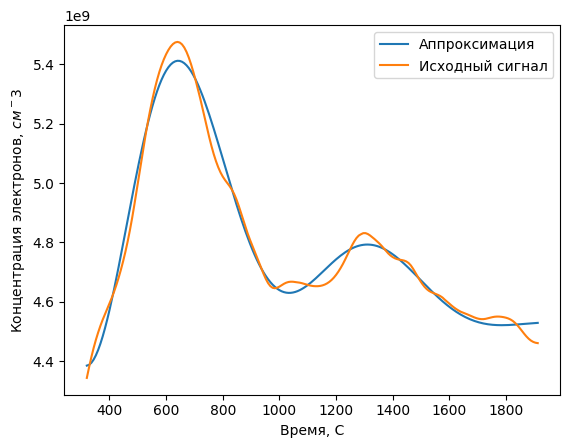

In [80]:
show_fited_electron_concentration_dependence(fited_electron_concentration_dependence)

In [81]:
def calculate_fited_temp_dependence(temp_dependence):
    L = time_distance_plot_A94.shape[1]
    times = [8 * i for i in range(40, L)]
    p = [6e6, 400, 3, 1/300, 6.5e6, -4e3, 0.1]
    x_values = times
    y_values_not_fited = temp_dependence
    popt, pcov = curve_fit(fit_func, x_values, y_values_not_fited, p0 = p, maxfev=3000)
    print(popt)
    y_values_trend_fited = [trend(x, popt[4], popt[5], popt[6]) for x in x_values]
    y_values_wave_fited = [wave(x, popt[0], popt[1], popt[2], popt[3]) for x in x_values]
    y_values_fit = [fit_func(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6]) for x in x_values]
    return popt, y_values_fit

In [82]:
temp_popt, fited_temp_dependence = calculate_fited_temp_dependence(temp_dependence)

[ 7.80636317e+06  7.45033710e+02  8.51118757e+00  2.17090073e-03
  8.77947980e+06 -5.69394769e+03  1.43850418e+00]


In [83]:
def show_fited_temp_dependence(fited_temp_dependence):
    L = time_distance_plot_A94.shape[1]
    times = [8 * i for i in range(40, L)]
    plt.plot(times, fited_temp_dependence, label = "Аппроксимация")
    plt.plot(times, temp_dependence, label = "Исходный сигнал")
    plt.xlabel("Время, С")
    plt.ylabel("Температура, K")
    plt.legend()
    plt.savefig("fited_temp")

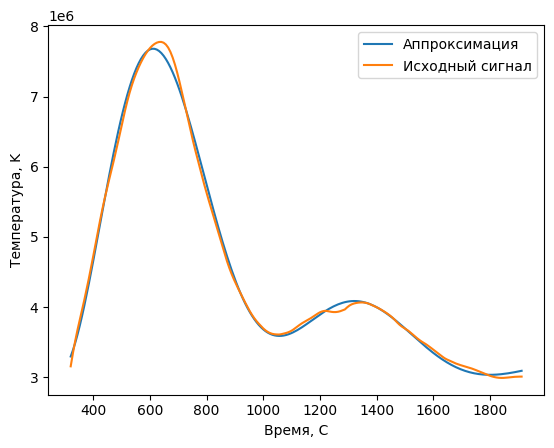

In [84]:
show_fited_temp_dependence(fited_temp_dependence)

In [85]:
def calculate_intensivity_of_bezier_segment_from_time_distance_plot(time_distance_plot: npt.NDArray, index_of_bezier_segment: int):
    length_of_time_distance_plot = time_distance_plot.shape[1]
    height_of_time_distance_plot = time_distance_plot.shape[0]
    t_values = [t for t in range(40, length_of_time_distance_plot)]
    y_values = [get_intensivity_of_bezier_segment_by_t(time_distance_plot, index_of_bezier_segment, t) for t in t_values]
    t_values = np.array(t_values)
    y_values = np.array(y_values)
    return y_values

In [86]:
intensivity_dependence_of_A131 = calculate_intensivity_of_bezier_segment_from_time_distance_plot(time_distance_plot_A131, index_of_most_intense_bezier_segment)

In [87]:
def show_intensivity_dependence_A131(intensivity_dependence):
    times = [8 * i for i in range(40, time_distance_plot_A131.shape[1])]
    plt.plot(times, intensivity_dependence)

In [88]:
def create_fited_intensivity_dependence_A131(intensivity_dependence):
    L = time_distance_plot_A131.shape[1]
    height_of_time_distance_plot = time_distance_plot_A131.shape[0]
    p = [100, 2*337, 3, 1/220, 120, -0.1, 0]
    x_values = [8 * i for i in range(40, L)]
    y_values_not_fited = [get_intensivity_of_bezier_segment_by_t(time_distance_plot_A131, index_of_most_intense_segment, i) for i in range(40, L)]
    popt, pcov = curve_fit(fit_func, x_values, y_values_not_fited, p0 = p, maxfev=3000)
    print(popt)
    y_values_fit = [fit_func(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6]) for x in x_values]
    return y_values_fit

In [89]:
fited_intensivity_dependence = create_fited_intensivity_dependence_A131(intensivity_dependence_of_A131)

[-7.93996559e+01  6.84359876e+02  4.87454348e+00  1.77531696e-03
  7.96939851e+01  1.06443034e-02 -1.93945233e-05]


In [90]:
def show_fited_intensivity_dependence_A131(fited_intensivity_dependence):
    L = time_distance_plot_A131.shape[1]
    x_values = [8 * i for i in range(40, L)]
    plt.plot(x_values, fited_intensivity_dependence, label = "Аппроксимация")
    plt.plot(x_values, intensivity_dependence_of_A131, label = "Исходный сигнал")
    plt.xlabel("Время, С")
    plt.ylabel("Интенсивность сигнала")
    plt.legend()

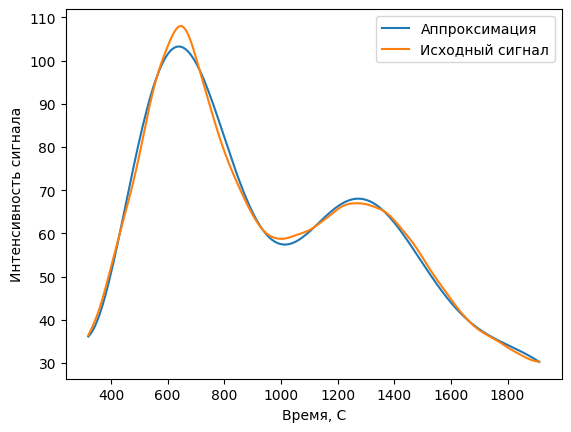

In [91]:
show_fited_intensivity_dependence_A131(fited_intensivity_dependence)

In [92]:
def show_fited_temp_and_electron_concentration_dependence():
    L = time_distance_plot_A131.shape[1]
    x_values = [8 * i for i in range(40, L)]
    e_popt = electron_conc_popt
    t_popt = temp_popt
    normalized_temp = [wave(x, t_popt[0],t_popt[1],t_popt[2],t_popt[3])/trend(x, t_popt[4],t_popt[5],t_popt[6]) for x in x_values]
    normalized_e_conc = [wave(x, e_popt[0],e_popt[1],e_popt[2],e_popt[3])/trend(x, e_popt[4],e_popt[5],e_popt[6]) for x in x_values]
    plt.plot(x_values, normalized_temp, label = "Температура")
    plt.plot(x_values, normalized_e_conc, label = "Электронная концентрация")
    plt.xlabel("Время, С")
    plt.ylabel("Относительная амплитуда")
    plt.legend()

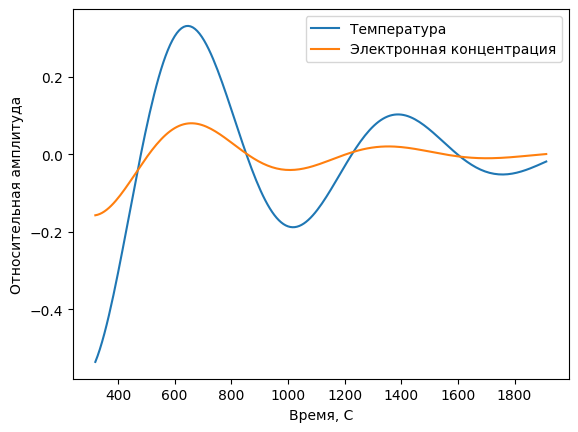

In [93]:
show_fited_temp_and_electron_concentration_dependence()